In [1]:
from pythtb import WFArray, Mesh, Lattice, TBModel
from pythtb.models import kane_mele
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_kane_mele(topological):
    "Return a Kane-Mele model in the normal or topological phase."

    # on-site energy parameter
    if topological == "even":
        esite = 2.5
    elif topological == "odd":
        esite = 1.0

    # Fixed model parameters
    thop = 1.0  # nearest-neighbor hopping
    spin_orb = 0.6 * thop * 0.5  # spin-orbit coupling
    rashba = 0.25 * thop  # Rashba coupling

    # define lattice vectors
    lat_vecs = [[1, 0], [1 / 2, np.sqrt(3) / 2]]
    # define coordinates of orbitals
    orb_vecs = [[1 / 3, 1 / 3], [2 / 3, 2 / 3]]

    lat = Lattice(lat_vecs, orb_vecs, periodic_dirs=...)
    ret_model = TBModel(lattice=lat, spinful=True)

    # set on-site energies
    ret_model.set_onsite([esite, -esite])

    # four-vector multiplying I and 3 Pauli matrices
    sigma_x = np.array([0, 1, 0, 0])
    sigma_y = np.array([0, 0, 1, 0])
    sigma_z = np.array([0, 0, 0, 1])

    # set hoppings (one for each connected pair of orbitals)
    # (amplitude, i, j, [lattice vector to cell containing j])

    # spin-independent first-neighbor hoppings
    R_vectors = [[0, 0], [0, -1], [-1, 0]]
    for R in R_vectors:
        ret_model.set_hop(thop, 0, 1, ind_R=R, mode="add")

    # Rashba first-neighbor hoppings: (s_x)(dy)-(s_y)(d_x)
    # bond unit vectors are (np.sqrt(3) / 2, 1/2) then (0,-1) then (-np.sqrt(3) / 2, 1/2)
    bond_vectors = [
        [np.sqrt(3) / 2, 1 / 2],
        [0, -1],
        [-np.sqrt(3) / 2, 1 / 2],
    ]
    for bv, R in zip(bond_vectors, R_vectors):
        dx = bv[0]
        dy = bv[1]
        rashba_hop = 1j * rashba * (dy * sigma_x - dx * sigma_y)
        ret_model.set_hop(
            rashba_hop,
            0,
            1,
            ind_R=R,
            mode="add",
        )

    # second-neighbour spin-orbit hoppings (s_z)
    nnn_hop = 1j * spin_orb * sigma_z
    ret_model.set_hop(-nnn_hop, 0, 0, [0, 1])
    ret_model.set_hop(nnn_hop, 0, 0, [1, 0])
    ret_model.set_hop(-nnn_hop, 0, 0, [1, -1])
    ret_model.set_hop(nnn_hop, 1, 1, [0, 1])
    ret_model.set_hop(-nnn_hop, 1, 1, [1, 0])
    ret_model.set_hop(nnn_hop, 1, 1, [1, -1])

    ret_model = kane_mele(esite, thop, spin_orb, rashba)

    return ret_model

In [3]:
model_triv = get_kane_mele("even")
model_topo = get_kane_mele("odd")

Text(0.5, 1.0, 'Kane-Mele: topological phase')

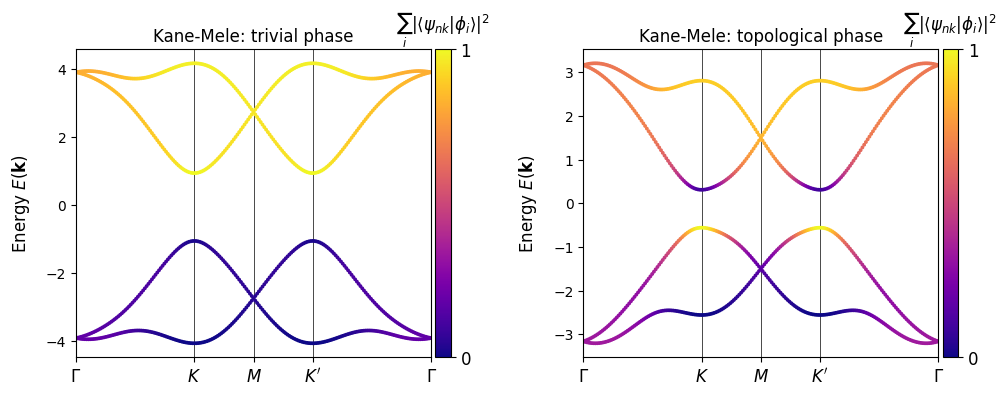

In [4]:
# initialize figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# list of nodes (high-symmetry points) that will be connected
k_nodes = [
    [0, 0],
    [2 / 3, 1 / 3],
    [1 / 2, 1 / 2],
    [1 / 3, 2 / 3],
    [0, 0],
]

# labels of the nodes
label = (r"$\Gamma $", r"$K$", r"$M$", r"$K^\prime$", r"$\Gamma $")

# solve for eigenenergies of hamiltonian on k_path and plot bands
model_triv.plot_bands(
    k_nodes=k_nodes, nk=201, k_node_labels=label, fig=fig, ax=ax1, proj_orb_idx=[0]
)
model_topo.plot_bands(
    k_nodes=k_nodes, nk=201, k_node_labels=label, fig=fig, ax=ax2, proj_orb_idx=[0]
)

ax1.set_title("Kane-Mele: trivial phase")
ax2.set_title("Kane-Mele: topological phase")

In [5]:
mesh = Mesh(["k", "k"])
mesh.build_grid(shape=(41, 41), gamma_centered=True)
print(mesh)

Mesh Summary
Type: grid
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 1681
Full shape: (41, 41, 2)
k-axes: [Axis(type=k, name=k_0, size=41), Axis(type=k, name=k_1, size=41)]
λ-axes: []
Is a torus in k-space (all k-axes wind BZ): yes
Loops: (axis 0, comp 0, winds_bz=yes, closed=no), (axis 1, comp 1, winds_bz=yes, closed=no)


In [6]:
wf_array_topo = WFArray(model_topo.lattice, mesh, spinful=True)
wf_array_topo.solve_model(model=model_topo)

wf_array_triv = WFArray(model_triv.lattice, mesh, spinful=True)
wf_array_triv.solve_model(model=model_triv)

In [7]:
wan_cent_topo = wf_array_topo.berry_phase(
    axis_idx=1, state_idx=[0, 1], contin=True, berry_evals=True
)
wan_cent_topo /= 2 * np.pi

wan_cent_triv = wf_array_triv.berry_phase(
    axis_idx=1, state_idx=[0, 1], contin=True, berry_evals=True
)
wan_cent_triv /= 2 * np.pi

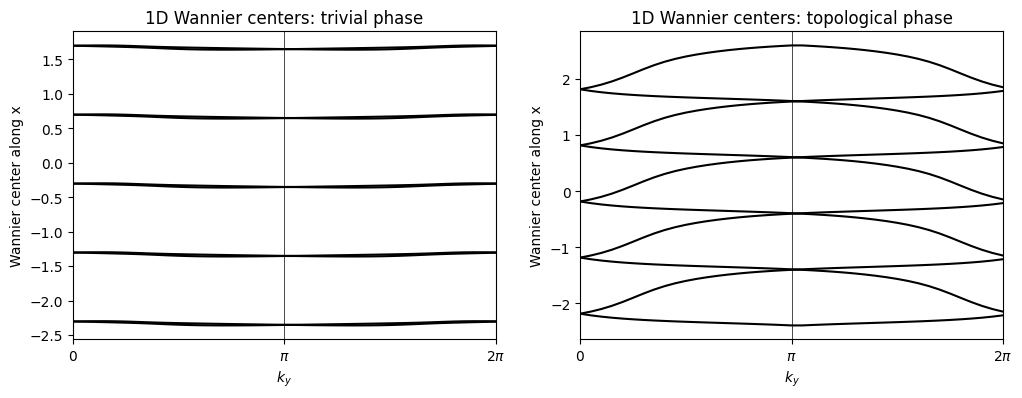

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# trivial
nky = wan_cent_triv.shape[0]
ky = np.linspace(0, 1, nky)

# draw shifted Wannier center positions
for shift in range(-2, 3):
    ax[0].plot(ky, wan_cent_triv[:, 0] + float(shift), "k")
    ax[0].plot(ky, wan_cent_triv[:, 1] + float(shift), "k")

ax[0].set_ylabel("Wannier center along x")
ax[0].set_xlabel(r"$k_y$")
ax[0].set_xticks([0.0, 0.5, 1.0])
ax[0].set_xlim(0.0, 1.0)
ax[0].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$"])
ax[0].axvline(x=0.5, linewidth=0.5, color="k")
ax[0].set_title("1D Wannier centers: trivial phase")

# topological
nky = wan_cent_topo.shape[0]
ky = np.linspace(0, 1, nky)

# draw shifted Wannier center positions
for shift in range(-2, 3):
    ax[1].plot(ky, wan_cent_topo[:, 0] + float(shift), "k")
    ax[1].plot(ky, wan_cent_topo[:, 1] + float(shift), "k")

ax[1].set_ylabel("Wannier center along x")
ax[1].set_xlabel(r"$k_y$")
ax[1].set_xticks([0.0, 0.5, 1.0])
ax[1].set_xlim(0.0, 1.0)

ax[1].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$"])
ax[1].axvline(x=0.5, linewidth=0.5, color="k")

ax[1].set_title("1D Wannier centers: topological phase")
plt.show()